Import necessary packages

In [333]:
using Random
using CSV, DataFrames
using Plots
using OrdinaryDiffEq, DiffEqSensitivity
using Zygote, ForwardDiff
using Flux
using Flux.Optimise: update!
using Flux.Losses: mae, mse
using BSON: @save, @load
using ProgressBars, Printf


Load and visualize experimental data

In [334]:
#LOAD FILES 
file_path = raw"C:\Users\Arjun\Desktop\CRNN\Anode_from_scratch\dataset.csv"
data = CSV.read(file_path, DataFrame)
time_exp = data[:, 1];  # Column 1 is time in min
temp_exp = data[:,2]; #Column 2 is temp of sample in °C
heat_flow = data[:, 3];    # Column 3 is heat flow in W/kg


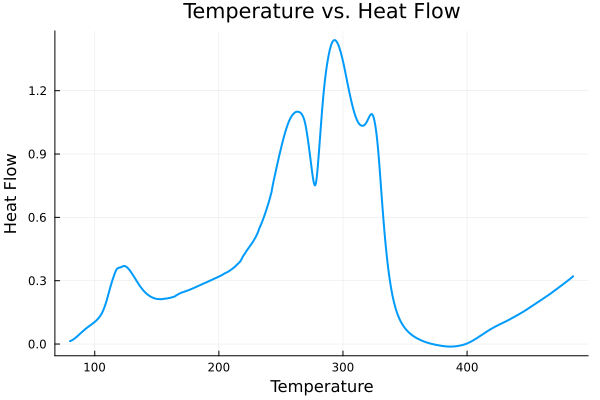

In [335]:
#VISUALIZE DATA 
plot(temp_exp, heat_flow, xlabel="Temperature", ylabel="Heat Flow", title="Temperature vs. Heat Flow", lw=2, legend=false)


Model argument setup

In [336]:
Random.seed!(1234); #Allows reproducibility; ensures any random generated along the process remains the same in any future runs

is_restart = false; #To ensure simulation does not start from a previous state 

p_cutoff = 0.0;

n_epochs = 60000; #Number of training epochs

n_plot = 100; #Frequency of plotting; plot every 100 epochs

opt = Flux.ADAM(); #ADAM optimizer from FLUX library

datasize = 100; #100 datapoints per experiment

tstep = 0.4; #Timestep chosen for simulations

n_exp_train = 20; #No: of experiments in training set

n_exp_test = 10; #No: of experiments in testing set

noise = 5f-2; #Noise of 0.05 where f indicates a decimal with float32 format

ns = 5; #No: of state variables

nr = 3; #No: of reactions

alg = Tsit5(); #5th order Tistouras Runge-Kutta method for ODE solver

atol = 1e-5; #Absolute tolerance
rtol = 1e-2; #Relative tolerance

maxiters = 10000; #Maximum iterations for the ODE solver to prevent it from running indefenitly

lb = 1f-5; #Lower bound and upperbounds for certain parameters in float32 format
ub = 1f1;

n_exp = 1;

grad_max= 1.e2;

#Experiment specific. Currently we try code for one specific 5K/min experiment
#beta = 5 #5K/min
#T0 = 80 #°C 

lr_adam = 1.e-3;
w_decay = 1.e-7;

Trainable kinetic parameters definition

In [337]:
# TRAINABLE KINETIC PARAMETERS DEFINITION + INITIALIZATION

np = 21+1 #21 kinetic based parameters + an additional parameter for slope based correction
p = randn(Float64, np) .* 1.e-2; #Set as Float32

#Order of kinetic parameters in vector [LiC1, LiC2, Li-EC, B]

# 4 pre-exponential factors
p[1:4] .+= 1;  

# 4 Activation energies
Ea_IC=[0.3, 1.4, 1.2, 1] #List of initial conditions for activation energies
p[5]+=Ea_IC[1] #Activation energy for reaction SEI growth in region 2 (100°C-200°C)
p[6]+=Ea_IC[2] #Activation energy for reaction of SEI decomposition in region 3 (200°C-300°C)
p[7]+=Ea_IC[3] #Activation energy for reaction of Lithiated graphite and Electrolyte in region 2 (200°C-300°C)
p[8]+=Ea_IC[4] #Activation energy of binder reactions (above 300°C)

# 4 Enthalpy of reaction (deltaH)
#Initialized higher values for peak 2 and peak 3 because of their relative sizes compared to peak 1 and peak 4

p[13] += 0.2; #Enthalpy for reaction SEI growth in region 2 (100°C-200°C)
p[14] += 1; #Enthalpy for reaction of SEI decomposition in region 3 (200°C-300°C)
p[15] += 0.8; #Enthalpy for reaction of Lithiated graphite and Electrolyte in region 2 (200°C-300°C)
p[16] += 0.5; #Enthalpy of binder reactions (above 300°C)

p[17:20] .+= 1; #Reaction orders for all reactions are initialized at 1.0

p[21]= 0.5; #Alpha conversion factor for competing parallel reaction in region 3

p[22]= 0.1; #slope, as per original CRNN code



0.1

SETUP parameters to weight vectors with clamps to prevent over-estimation

In [338]:
function p2vec(p)
    
    #some clamps in place during debugging to make sure none of the parameters get too large or small 
    #these don't appear to be necessary in the final runs

    slope = p[end] .* 1.e1
    
    #logA #Unit depends on reaction order
    w_A = p[1:4] .* (slope * 20.0)
    w_A = clamp.(w_A, 0, 50) 

    #rxn orders; unit depends on reaction order
    #To avoid negative values for order + typical orders are within 10 
    w_in_order=p[17:20] 
    w_in_order=clamp.(w_in_order, 0.01, 10) 

    #Ea; units: J/mol if using R or J if using kB
    #Negative activation energy is unphysical -> We need energy to drive reaction!
    w_in_Ea = abs.(p[5:8]) 
    w_in_Ea = clamp.(w_in_Ea, 0.0, 3) 

    #non-exponential temp dependence, can be negative, no clamp, dimensionless
    w_in_b = (p[9:12]) 

    #delH units: Joules/kg
    #Non-negative since it represent energy change; scaled with 100 for unit conversion
    w_delH = abs.(p[13:16])*100 
    w_delH = clamp.(w_delH, 10, 300) 

    #To show if one reaction progress more actively than the other
    w_alpha = p[21]
    w_alpha = clamp.(w_alpha,0,1) 
    
    return w_in_Ea, w_in_b, w_delH, w_in_order, w_A, w_alpha
end

p2vec (generic function with 1 method)

Function to convert time points in the ODE to temperature values based on heating rate β  K/min

In [339]:
function getsampletemp(t, T0, beta)
    if beta < 100
        T = T0 .+ beta / 60 * t  # K/min to K/s
    end
    return T
end


getsampletemp (generic function with 1 method)

CRNN function for Anode

In [340]:
#Function based constants

const tsei1r = 0.033 #Tunneling reference factor for secondary SEI buildup; dimensionless
const tsei2r = 0.033
const R = -1.0/8.314 #Based on R (J/mol K)


-0.12027904738994467

In [341]:
function anode_crnn!(du, u, p, t)
    # u would be a sent as a list with order [xLiC1, tsei1, xLiC2, tsei2, xB]
    # du/dt would be a list with the ODE [dxLiC1/dt, dtsei1/dt, dxLiC2/dt, dtsei2/dt, dxB/dt]
    # To write ODE's with ease, we split concentration and thickness state variables

    conc = [u[1],u[3],u[3],u[5]] #Shape (4,); [xLiC1, xLiC2, xLiC2, xB]
                                #XLiC1 for region 2, xLiC2 twice for the two reactions in region 3, xB for region 4
    sei = [u[2],u[4]] #Shape (2,); [tsei1, tsei2]

    logX = @. log(clamp(conc,lb,10.0)) #Shape (4,)
    S = @. clamp(sei,lb,0.099) #Shape (2,)

    #In CRNN function, we evaluate at a given time point; so T would be a scalar
    T = getsampletemp(t, T0, beta) 
    
    temp_term= reshape(hcat(log(T), R/T)*hcat(w_in_b, w_in_Ea*10^5)', 4) #Temp term has size (4,)
    rxn_ord_term = w_in_order .* logX

    pre_rxn_rates = temp_term + rxn_ord_term + w_A
    pre_rxn_rates[1] -= S[1] / tsei1r
    pre_rxn_rates[2] -= S[2] / tsei2r

    pre_rxn_rates = @. exp(pre_rxn_rates)

    # Assign to du
    du[1] = -(pre_rxn_rates[1])
    du[2] = pre_rxn_rates[1]
    du[3] = -(pre_rxn_rates[2] + pre_rxn_rates[3])
    du[4] = -pre_rxn_rates[2]
    du[5] = -pre_rxn_rates[4]
end
    

anode_crnn! (generic function with 1 method)

In [342]:
#SETUP the ODE Problem to solve the ODE above

tspan = [0.0, 1.0]; #At this stage tspan is only intended to define the ODE Problem. Real tspan must come from experimental data.
u0 = [1.0, 0.04, 1.0, 0.055, 1.0]; #All normalized concentrations set at 1.0; tsei1 set smaller than tsei2
prob = ODEProblem(anode_crnn!,u0,tspan,p,abstol = atol)

#SETUP Solution algorithm
alg = AutoTsit5(TRBDF2(autodiff = true));
sense = ForwardSensitivity(autojacvec = true)

ForwardSensitivity{0, true, Val{:central}}(true, false)

In [343]:
# SETUP a snippet to stop the integrator if solver computes unphysical values like negative concentrations or negative tunneling 

threshold1 = lb #Concentration of LiC1
threshold2 = lb 
threshold3 = lb #Concentration of LiC2
threshold4 = lb
threshold5 = lb #Concentration of b

thresholds = [threshold1, threshold2, threshold3, threshold4, threshold5]  # Define the thresholds

condition(u, t, integrator) = any(u[i] < thresholds[i] for i in 1:length(u))

# Define the affect function
affect!(integrator) = terminate!(integrator)

# Create the DiscreteCallback
_cb = DiscreteCallback(condition, affect!)


DiscreteCallback{typeof(condition), typeof(affect!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}(condition, affect!, SciMLBase.INITIALIZE_DEFAULT, SciMLBase.FINALIZE_DEFAULT, Bool[1, 1])

In [344]:
#To check if ODE is solvable at currently defined parameters

#ts = @view (data[:,1]);
#tspan = [ts[1], ts[end]];
#sol = solve(prob,alg, tspan = tspan, p = p, saveat = ts, sensealg = sense, maxiters = maxiters);


CRNN! computes state variables at each time step; one at a time. This matrix is used to compute the heatflow vs time using the HRR_getter function below

In [345]:
function HRR_getter(times, u_outputs)
    # Extract parameters
    num_times = length(times)

    #u_outputs have shape (5,num_times); hence transposed to have num_times no: of rows and 5 column vectors representing a state variable
    u_out = u_outputs'

    conc_prof = zeros(num_times,4) 
    
    conc_prof[:, 1] .= u_out[:, 1]
    conc_prof[:, 2] .= u_out[:, 3]
    conc_prof[:, 3] .= u_out[:, 3]
    conc_prof[:, 4] .= u_out[:, 5]

    thick_prof = zeros(num_times,2)
    thick_prof[:, 1] .= u_out[:, 2]
    thick_prof[:, 2] .= u_out[:, 4]


    log_conc_prof = @. log(clamp(conc_prof, lb, 10.0)) #(num_times,4)

    S_prof = @. clamp(thick_prof, lb, 0.099)
    

    # Temperature-dependent terms
    T = getsampletemp(times, T0, beta) #times is of shape (num_times,); so T is of shape (num_times,)

    
    # Reshape T for broadcasting
    log_T = log.(T) #shape (15682,)

    temp_term1 = log_T .* w_in_b' #(num_times,1) .* (1,4)-> (num_times,4) matrix

    temp_term2 = (R ./ T) .* (w_in_Ea* 1e5)' #(num_times,1) .* (1,4)-> (num_times,4) matrix

    temp_term = temp_term1 .+ temp_term2 #element wise addition; shape (num_times,4)

    rxn_ord_term = log_conc_prof.*w_in_order' #size (num_times,4)

    comb_term = temp_term .+ rxn_ord_term #size (num_times,4)


    # Combining with pre-exponential factor
    pre_rxn_rates = comb_term .+ w_A' #(num_times,4)

    # Adjustments for specific reactions
    pre_rxn_rates[:, 1] .= pre_rxn_rates[:, 1] .- S_prof[:, 1] / tsei1r
    pre_rxn_rates[:, 2] .= pre_rxn_rates[:, 2] .- S_prof[:, 2] / tsei2r

    #pre_rxn_rates shape: (num_times,4)

    #pre_rxn_rates = clamp.(pre_rxn_rates, -700, 700)


    rxn_rates = @. exp(pre_rxn_rates) #size: (num_times,4)

    return rxn_rates
end

HRR_getter (generic function with 2 methods)

In [346]:
function pred_n_ode(p)
    
    global beta = 5 #K/min
    global T0=80+273.15 #degrees K 
    global w_in_Ea, w_in_b, w_delH, w_in_order, w_A, w_alpha = p2vec(p)

    ts = @view (data[:,1]);
    tspan = [ts[1], ts[end]];
    
    tsei1r = 0.033 #Tunneling reference factor for secondary SEI buildup; dimensionless
    tsei2r = 0.033
    R = -1.0/8.314 #Based on R (J/mol K)

    #solve the species trajetory, which is independent of heat release (idealized DSC system):
    sol = solve(
        prob,
        alg,
        tspan = tspan,
        p = p,
        saveat = ts,
        sensealg = sense,
        maxiters = maxiters,
    )

    #post-processing: compute the heat release (actual desired solution) from the species trajectory:
    heat_rel= HRR_getter(ts, sol[:, :]).*w_delH' #(num_times,4).*(1,4) -> (num_times,4)


    if sol.retcode == :Success
        nothing
    else
        @sprintf("solver failed")
    end

    return heat_rel, ts, sol
end

pred_n_ode (generic function with 1 method)

In [347]:
function loss_neuralode(p)
    pred = Array(pred_n_ode(p)[1]) #index=1 extracts first item from the tuple, i.e heat release rates which itself is a matrix of size (num_times,4)
                                   #Array converts to a format that is suitable for next steps
                                   #Size (num_times,4)
    pred_total = sum(pred, dims=2)[:, 1]  # Summing along columns to get a (num_times,) vector
    #sum(pred,dims =2) gives a matrix of shape (num_times,1) and [:,1] converts into a vector of size (num_times,)
    loss = mae(pred_total, @view(data[:, 3])) #index=3 for real heat releases
    
    return loss
end

loss_neuralode (generic function with 1 method)

In [348]:
@time loss = loss_neuralode(p)

6.492074137204123

TRAINING THE NN to reduce loss

In [349]:
function display_p(p)
    w_in_Ea, w_in_b, w_alpha, w_delH, w_in_order, w_A = p2vec(p);
    println("species (column) reaction (row)")
    println("rxn ord")
    show(stdout, "text/plain", round.(w_in_order', digits=3)) 
    
    println("\nEa")
    show(stdout, "text/plain", round.(w_in_Ea', digits=3)) 
    
    println("\nb")
    show(stdout, "text/plain", round.(w_in_b', digits=3)) 
    
    println("\ndelH")
    show(stdout, "text/plain", round.(w_delH', digits=3))
    
    println("\nlnA")
    show(stdout, "text/plain", round.(w_A', digits=3))
end
display_p(p)

Callback function to observe training

In [350]:
function plot_sol(HR1, HR2, HR3, HR4, exp_data, Tlist)
    beta = 5 #K/min
    
    T0=80+273.15

    sol=HR1+HR2+HR3+HR4

    ind = length(Tlist)
    plt = plot(
        Tlist,
        exp_data,
        seriestype = :scatter,
        label = "Exp",
    )

    plot!(
        plt,
        Tlist,
        HR1,
        lw = 3,
        legend = :left,
        label = "Region 2 (Peak 1)",
    )
    plot!(
        plt,
        Tlist,
        HR2,
        lw = 3,
        legend = :left,
        label = "Region 3: SEI Decomposition",
    )
    plot!(
        plt,
        Tlist,
        HR3,
        lw = 3,
        legend = :left,
        label = "Region 3: Li-EC reaction",
    )
    plot!(
        plt,
        Tlist,
        HR4,
        lw = 3,
        legend = :left,
        label = "Region 4: Binder reactions"
    )
    plot!(
        plt,
        Tlist,
        sol,
        lw = 3,
        legend = :left,
        label = "CRNN sum",
    )

    xlabel!(plt, "Time [min]")
    ylabel!(plt, "HRR")
    title!(plt)
    exp_cond = string(
        @sprintf(
            "T0 = %.1f K \n beta = %.2f K/min",
            T0,
            beta,
        )
    )
    

    p2 = plot(Tlist, sol, lw = 2, legend = :right, label = "heat release")
    xlabel!(p2, "Time [min]")
    ylabel!(p2, "W/g")

    plt = plot(plt, p2, framestyle = :box, layout = @layout [a; b])
    plot!(plt, size = (800, 800))
    return plt
end

cbi = function (p)
    
    exp_data = data[:,3] #Actual heat flow data for the current experiment
    
    sol = pred_n_ode(p)[1] #sol is a tuple that but index 1 extracts heat release which is a heat_rel matrix of shape (num_times,4). Not converted to Array format since it may disrupt calculations of gradient
    times = pred_n_ode(p)[2] #times at which heat is calculated
    raw_sol=pred_n_ode(p)[3] #concentration data + tunneling dynamics due to SEI growth and degradation
    
    #HRR_Getter takes in current statevariables from raw_sol and returns rate_eqn matrix of shape (num_times,5). [:,1] for eg extracts the rate of statevariable at index 1, ie LiC1
    HR1=HRR_getter(times, raw_sol[:, :])[:, 1]*w_delH[1] #HR1 for region 2
    HR2=HRR_getter(times, raw_sol[:, :])[:, 3]*w_delH[2] #For reaction 1 in region 3
    HR3=HRR_getter(times, raw_sol[:, :])[:, 3]*w_delH[3] #For reaction 2 in region 3
    HR4=HRR_getter(times, raw_sol[:, :])[:, 5]*w_delH[4] #For region 4
    
    Tlist = similar(times)
    #similar would create an uninitialized array of the same shape and type as times; it does not initialize it with zeros or ones, but rather can store whatever was in memory at the location at the epoch
    
    T0=80+273.15
    beta = 5 #K/min
    for (i, t) in enumerate(times)
        Tlist[i] = getsampletemp(t, T0, beta)
    end
    
    plt = plot_sol(HR1, HR2, HR3, exp_data, Tlist)
    png(plt, string("C:\\Users\\Arjun\\Desktop\\CRNN\\Anode_from_scratch\\figs", "/pred_exp.png"))

    return false
end


#46 (generic function with 1 method)

Callback function to observe loss; also internally calls the callback function to plot 

In [351]:
l_loss_train = [] #Stores the loss after each epoch. Could be used to plot the loss as it propagates through epochs
list_grad = [] #Stores grad norm similarly
iter = 1

function plot_loss(l_loss_train; yscale = :log10)
    plt_loss = plot(l_loss_train, yscale = yscale, label = "train")
    plt_grad = plot(list_grad, yscale = yscale, label = "grad_norm")
    xlabel!(plt_loss, "Epoch")
    ylabel!(plt_loss, "Training_Loss")
    xlabel!(plt_grad, "Epoch")
    ylabel!(plt_grad, "Gradient Norm")

    plt_all = plot([plt_loss, plt_grad]..., legend = :top, framestyle=:box)
    plot!(
        plt_all,
        size=(1000, 450),
        xtickfontsize = 11,
        ytickfontsize = 11,
        xguidefontsize = 12,
        yguidefontsize = 12,
    )
    png(plt_all, "C:\\Users\\Arjun\\Desktop\\CRNN\\Anode_from_scratch\\loss\\loss_grad.png")
end


cb = function (p, loss_train, g_norm) #Anonymous function cb that takes current parameters p at current epoch
    global l_loss_train, list_grad, iter
    
    if !isempty(l_loss_train)
        if loss_train<minimum(l_loss_train) #Checks if current loss is the lowest seen so far
            global p_opt=deepcopy(p) #if so, parameters corresponding to the lowest loss is stored in p_opt
        end
    end
    push!(l_loss_train, loss_train)
    push!(list_grad, g_norm)
    #puts current loss_train and g_norm values into the list l_loss_train and list_grad that stores them over epochs

    if iter % n_plot == 0 || iter==1
        display_p(p)
        if @isdefined p_opt
            @printf("parameters of lowest yet loss:")
            display_p(p_opt)
        end
        
        @printf(
            "Min Loss train: %.2e val: %.2e",
            minimum(l_loss_train)
        )

        cbi(p) #plots the current state of predicted HRR and actual heat flow at the chosen iters!

        plot_loss(l_loss_train; yscale = :log10)
    end
    iter += 1
end



#49 (generic function with 1 method)

TRAINING

In [352]:
opt = ADAMW(lr_adam, (0.9, 0.999), w_decay);

In [357]:
epochs = ProgressBar(iter:n_epochs);
loss_epoch = zeros(Float64, n_epochs); #For now creates an array of size 1 since only one expt (stores the loss at each epoch of this expt)
grad_norm = zeros(Float64, n_epochs);

for epoch in epochs
    global p

    grad = ForwardDiff.gradient(x -> loss_neuralode(x), p) #Computes loss and then its gradients wrt p
    grad_norm[epoch] = norm(grad, 2)

    if grad_norm[epoch] > grad_max
        grad = grad ./ grad_norm[epoch] .* grad_max
    end

    update!(opt, p, grad)

    loss_epoch[epoch] = loss_neuralode(p)

    set_description(
        epochs,
        @sprintf(
            "Epoch %d: Loss: %.2e Grad Norm: %.2e",
            epoch,
            loss_epoch[epoch],
            grad_norm[epoch],
        ),
    )

    cb(p, loss_epoch[epoch], grad_norm[epoch])
end



MethodError: MethodError: no method matching Float64(::ForwardDiff.Dual{ForwardDiff.Tag{var"#53#54", Float64}, Float64, 11})
Closest candidates are:
  (::Type{T})(::Real, !Matched::RoundingMode) where T<:AbstractFloat at rounding.jl:200
  (::Type{T})(::T) where T<:Number at boot.jl:760
  (::Type{T})(!Matched::VectorizationBase.Double{T}) where T<:Union{Float16, Float32, Float64, VectorizationBase.Vec{var"#s38", var"#s37"} where {var"#s38", var"#s37"<:Union{Float16, Float32, Float64}}, VectorizationBase.VecUnroll{var"#s36", var"#s35", var"#s34", V} where {var"#s36", var"#s35", var"#s34"<:Union{Float16, Float32, Float64}, V<:Union{Bool, Float16, Float32, Float64, Int16, Int32, Int64, Int8, UInt16, UInt32, UInt64, UInt8, SIMDTypes.Bit, VectorizationBase.AbstractSIMD{var"#s35", var"#s34"}}}} at C:\Users\Arjun\.julia\packages\VectorizationBase\LqJbS\src\special\double.jl:111
  ...